## Loading Image and Label

In [1]:
import nibabel as nib
import matplotlib.pyplot as plt

In [2]:
image = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/imagesTr/10005_1000005.nii.gz').get_fdata()
label = nib.load('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/labelsTr/10005_1000005.nii.gz').get_fdata()

In [3]:
print(image.shape)
print(label.shape)

(384, 384, 19, 3)
(384, 384, 19)


In [4]:
import numpy as np

print("Min value:", np.min(image))
print("Max value:", np.max(image))
print("Mean value:", np.mean(image))
print("Unique values:", np.unique(image))


Min value: 0.0
Max value: 3476.0
Mean value: 243.2140934815881
Unique values: [0.000e+00 1.000e+00 2.000e+00 ... 3.452e+03 3.472e+03 3.476e+03]


## Visualizing Slice and True Segmentation

In [5]:
slice = 8
img_data = image[:, :, slice]
label_data = label[:, :, slice]

img_data = (img_data - np.min(img_data)) / (np.max(img_data) - np.min(img_data))

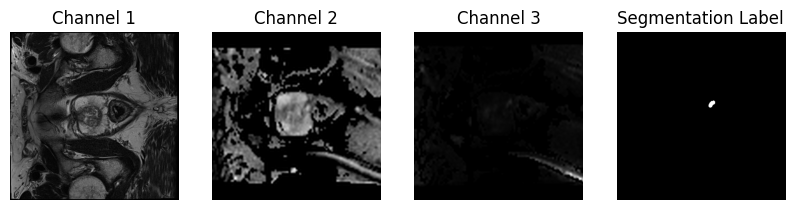

In [6]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))

axes[0].imshow(img_data[:, :, 0], cmap="gray")
axes[0].set_title("Channel 1")
axes[0].axis("off")

axes[1].imshow(img_data[:, :, 1], cmap="gray")  
axes[1].set_title("Channel 2")
axes[1].axis("off")

axes[2].imshow(img_data[:, :, 2], cmap="gray")  
axes[2].set_title("Channel 3")
axes[2].axis("off")

axes[3].imshow(label_data, cmap="gray")  
axes[3].set_title("Segmentation Label")
axes[3].axis("off")
plt.show()

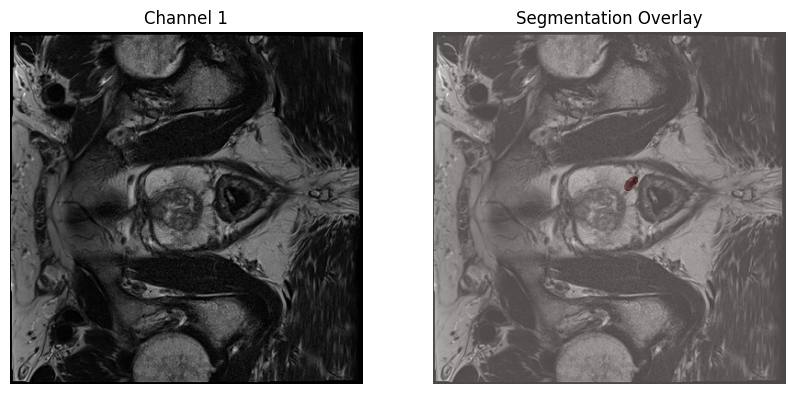

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_data[:, :, 0], cmap="gray")
axes[0].set_title("Channel 1")
axes[0].axis("off")

axes[1].imshow(img_data[:, :, 0], cmap="gray")  
axes[1].imshow(label_data, cmap="Reds", alpha=0.3)  
axes[1].set_title("Segmentation Overlay")
axes[1].axis("off")
plt.show()

## Pre-processing for Task

In [8]:
from monai import transforms as T
from glob import glob
import os
import numpy as np
import torch
from monai.transforms import LoadImage
from collections import Counter

image_files = sorted(glob(os.path.join('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/', "imagesTr", "*.nii.gz")))
label_files = sorted(glob(os.path.join('/cluster/projects/vc/data/mic/open/Prostate/PI-CAI/preped-images/images/', "labelsTr", "*.nii.gz")))

In [9]:
# Load images and labels
loader = LoadImage(image_only=True)
image_shapes = []
label_shapes = []
intensity_stats = []
label_coverage = []

for img_path, lbl_path in zip(image_files, label_files):
    image = loader(img_path)[:, :, :, 0]  # Load image
    label = loader(lbl_path)  # Load label
    
    # Save shapes
    image_shapes.append(image.shape)
    label_shapes.append(label.shape)

# Convert to numpy arrays
image_shapes = np.array(image_shapes)
label_shapes = np.array(label_shapes)

shape_list = [tuple(shape) for shape in image_shapes]
shape_counts = Counter(shape_list)
most_common_shape, most_common_count = shape_counts.most_common(1)[0]
total_images = len(image_shapes)
proportion = most_common_count / total_images

# Print Summary
print("=== Dataset Overview ===")
print(f"Total images: {len(image_files)}")
print(f"Image Shape Range: {image_shapes.min(axis=0)} - {image_shapes.max(axis=0)}")
print(f"Label Shape Range: {label_shapes.min(axis=0)} - {label_shapes.max(axis=0)}")
print(f"Mean Image Shape: {image_shapes.mean(axis=0)}")
print(f"Most Common Shape: {most_common_shape}")
print(f"Occurrences: {most_common_count}")
print(f"Proportion: {proportion:.2%}")

=== Dataset Overview ===
Total images: 408
Image Shape Range: [256 256  19] - [1024 1024   37]
Label Shape Range: [256 256  19] - [1024 1024   37]
Mean Image Shape: [554.19607843 554.19607843  22.50245098]
Most Common Shape: (384, 384, 19)
Occurrences: 71
Proportion: 17.40%


In [10]:
for img_path, lbl_path in zip(image_files, label_files):
    image = loader(img_path)[:, :, :, 0]  # Load image
    label = loader(lbl_path)  # Load label
    
    # Label coverage: Percentage of labeled pixels
    label_nonzero = np.count_nonzero(label)
    total_pixels = np.prod(label.shape)
    label_coverage.append(label_nonzero / total_pixels)
    
label_coverage = np.array(label_coverage)    
print(f"Label Coverage (Mean): {label_coverage.mean():.4f}, Range: {label_coverage.min():.4f} - {label_coverage.max():.4f}")


Label Coverage (Mean): 0.0009, Range: 0.0000 - 0.0090


In [11]:
for img_path, lbl_path in zip(image_files, label_files):
    image = loader(img_path)[:, :, :, 0]  # Load image
    label = loader(lbl_path)  # Load label
    
    #  Intensity statistics (Min, Max, Mean, Std)
    intensity_stats.append({
        "min": image.min(),
        "max": image.max(),
        "mean": image.mean(),
        "std": image.std()
    })
    
print(f"Intensity Min: {np.min([s['min'] for s in intensity_stats])}, Max: {np.max([s['max'] for s in intensity_stats])}")
print(f"Mean Intensity: {np.mean([s['mean'] for s in intensity_stats])} ± {np.std([s['mean'] for s in intensity_stats])}")


Intensity Min: 0.0, Max: 3444.0
Mean Intensity: 197.42250061035156 ± 85.12419128417969


In [12]:
default_preprocess = T.Compose(
                [
                    T.LoadImaged(keys=["image", "label"]),
                    T.EnsureChannelFirstd(keys=["image", "label"]),
                    T.Lambdad(keys="image", func=lambda x: x[:1]),
                    T.Orientationd(keys=["image", "label"], axcodes="RAS"),
                    T.Spacingd(
                        keys=["image", "label"],
                        pixdim=(0.5, 0.5, 1.2),
                        mode=("bilinear", "nearest"),
                    ),
                    T.Resized(keys=["image", "label"], spatial_size=[360, 360, 40])
            ])

In [13]:
augment =  T.Compose(
                [
                    T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=0),
                    T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=1),
                    T.RandFlipd(keys=["image", "label"], prob=0.5, spatial_axis=2),
                    T.NormalizeIntensityd(
                        keys="image", nonzero=True, channel_wise=True
                    ),
                    T.RandScaleIntensityd(keys="image", factors=0.1, prob=1.0),
                    T.RandShiftIntensityd(keys="image", offsets=0.1, prob=1.0),
                ]
            )

In [14]:
transform=T.Compose([default_preprocess, augment])

In [15]:
data = [
            {"image": img, "label": lbl} for img, lbl in zip(image_files[:10], label_files[:10])
        ]



In [16]:
loader = T.LoadImaged(keys=["image", "label"])
loaded_data = [loader(d) for d in data]  
final_data = transform(data)

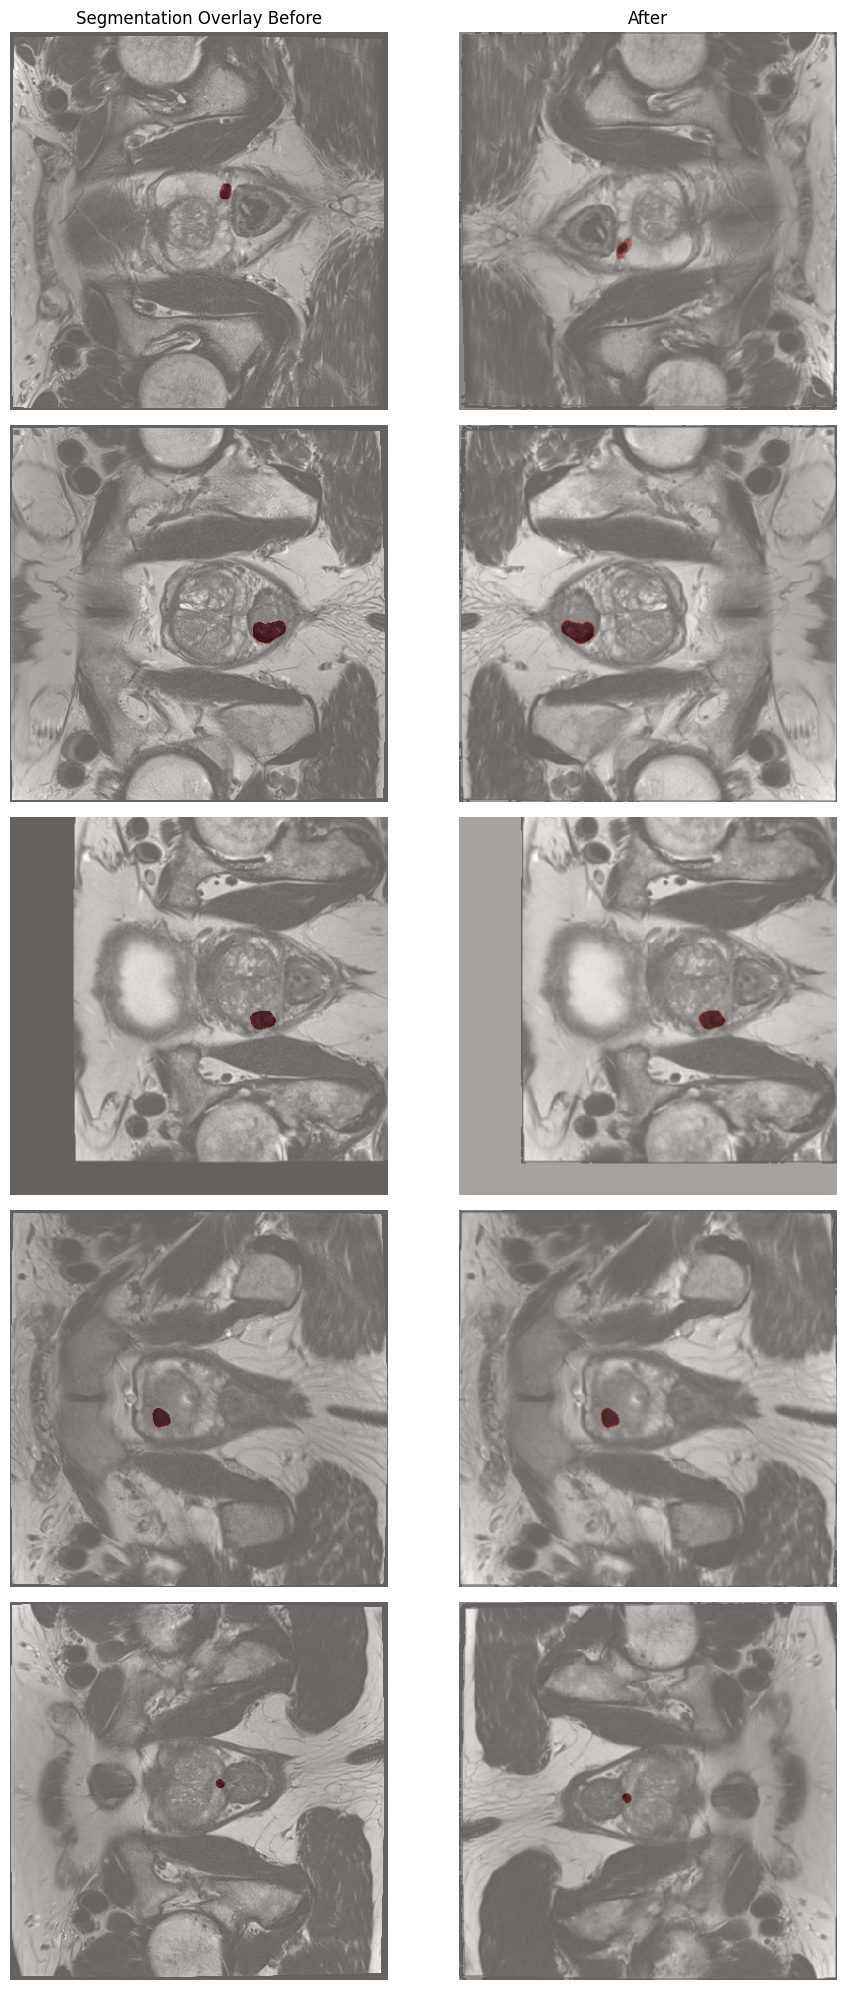

In [17]:
n = 5
fig, axes = plt.subplots(n, 2, figsize=(10,20))
axes[0,0].set_title("Segmentation Overlay Before")
axes[0,1].set_title("After")
for i in range(n):
    sample = loaded_data[i]
    label_slices = np.sum(sample["label"], axis=(0, 1))  
    slice = np.argmax(label_slices)  

    
    label_slices_final = np.sum(final_data[i]["label"][0], axis=(0, 1))
    slice_final = np.argmax(label_slices_final)

    axes[i, 0].imshow(sample['image'][:, :, slice, 0], cmap="gray")  
    axes[i, 0].imshow(sample["label"][:, :, slice], cmap="Reds", alpha=0.4)  
    axes[i, 0].axis("off")

    axes[i, 1].imshow(final_data[i]['image'][0, :, :, slice_final], cmap="gray")  
    axes[i, 1].imshow(final_data[i]["label"][0, :, :, slice_final], cmap="Reds", alpha=0.4)  
    axes[i, 1].axis("off")
plt.tight_layout()
plt.show()